# Multinomial logistic decoders

Multiclass data

Pytorch implementation
Doing it the Wrong Way (training multiple independent decoders)
Softmax
SKlearn fit

Using GPU resources
Confusion matrix
Continuous data, time series
Viterbi/HMM

Last week we ended with a PyTorch implementation of a multifeature logistic classifier. We were able to have it determine whether a thumb movement had been initiated based on the profile of spectral changes across multiple ECoG electrodes lying over motor cortex. Detecting whether a single movement has occurred is a binary output, True or False. This is limited. Ideally our decoder would be able to read-out a variety of movements. This problem is known as *multinomial classification*. For that, a set of features is given, just like before, and the probability of those features being associated with each of $K$ possibilities is returned. 

This week we will explore how to extend our logistic decoder to achieve this.

In [37]:
import os.path as op
import sys
from itertools import product
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from matplotlib import animation
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoader
from source.utils import zscore
from source.loaders import EcogFingerData
from source.decoders import LogRegPT, format_ecogfinger_data

Recall that each finger movement was associated with a distinctive spectral profile acros frequencies and channels.
![spectral profiles](./images/SpectralProfiles.png)

Also recall that when training our multifeature decoder to determine if a thumb movement was initiated or not, the weights used in the decoder had a similar appearance to its spectral profile, especially with L2 regularization.

![fitting coefficients](./images/FittingCoefficients.png)

If we want to decode multiple types of finger movements, then we could start by first training a separate decoder for each one. Then, the detected movement would be assigned by the one that returns the highest probability. **This approach will not work!** But, by implementing it, seeing how it fails, and fixing those failures, we will uncover how to properly construct a multinomial logistic decoder.  



## Multinomial decoding, the wrong way
Let's starting by loading in our data and importing our PyTorch based logistic decoder. We will use the PyTorch version because it will allow us directly implement changes required in making a multinomial logistic decoder. 

In [2]:
subj = 'cc'
ecog_path = ['..', 'data/ecog/', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path)

ecog_data = EcogFingerData(ecog_file)

finger_names = ['thumb', 'index', 'middle', 'ring', 'little']

In [34]:
# 5-fold stratified split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# sort data into train and test sets
flex_feats_tr = {}
flex_lbls_tr = {}
flex_feats_te = []
flex_lbls_te = []
for ind, finger in enumerate(finger_names):
    feats, lbls = format_ecogfinger_data(ecog_data, finger)
    n_trials = feats.shape[0]
    inds_tr, inds_te = next(skf.split(feats, lbls))
    flex_feats_tr[finger] = feats[inds_tr]
    flex_lbls_tr[finger] = lbls[inds_tr]
    flex_feats_te.append(feats[inds_te])
    flex_lbls_te.append(lbls[inds_te]*(ind+1))

flex_feats_te = np.concatenate(flex_feats_te, axis=0)
flex_lbls_te = np.concatenate(flex_lbls_te, axis=0)

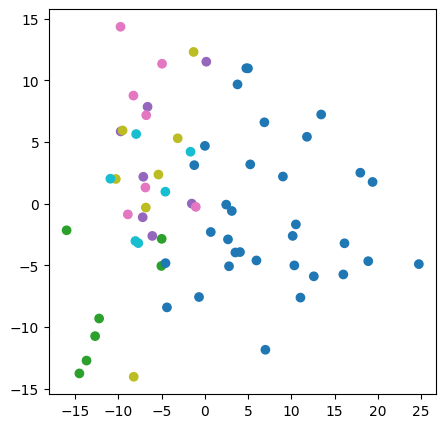

In [48]:
# get first two principal components of flex_feats_te
pca = PCA(n_components=5)
pca.fit(flex_feats_te)
flex_feats_te_pca = pca.transform(flex_feats_te)

# plot scores for first two principal components
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(flex_feats_te_pca[:, 0], flex_feats_te_pca[:, 2], c=flex_lbls_te, cmap='tab10')

In [49]:
# train a separate logistic regression model for each finger
lr_single = {}
lr_single_scores = {}
for finger in finger_names:
    lr_single[finger] = LogRegPT(train_prop=1.0) # use all data for training
    (lr_single_scores[finger]) = lr_single[finger].fit(flex_feats_tr[finger], flex_lbls_tr[finger])

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/drewheadle

In [50]:
lr_single_scores

{'thumb': (nan, 100.0),
 'index': (nan, 100.0),
 'middle': (nan, 100.0),
 'ring': (nan, 100.0),
 'little': (nan, 100.0)}

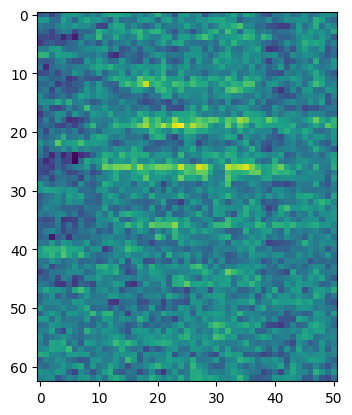

In [51]:
plt.imshow(lr_single['little'].get_coefs().reshape(63,51))


In [80]:
# get probability predictions for each finger decoder
pred_prob = np.zeros((flex_feats_te.shape[0], len(finger_names)))
for ind, finger in enumerate(finger_names):
    pred_prob[:,ind] = lr_single[finger].predict_proba(flex_feats_te)

# get predicted labels

# get maximum probability across fingers
pred_max = np.max(pred_prob, axis=1)

# find the finger with the maximum probability
pred_lbls = np.argmax(pred_prob, axis=1)+1

# if maximum predictions has probability less than 0.5 set to 0 (no finger)
pred_lbls[pred_max < 0.5] = 0



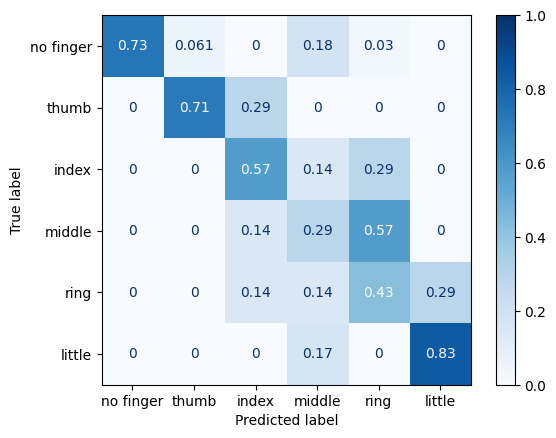

In [92]:
# plot confusion matrix
cm = confusion_matrix(flex_lbls_te, pred_lbls, normalize='true')
# set plot color limits to 0 to 1
cmd = ConfusionMatrixDisplay(cm, display_labels=['no finger']+finger_names)
im = cmd.plot(cmap='Blues')
im.im_.set_clim(0,1)

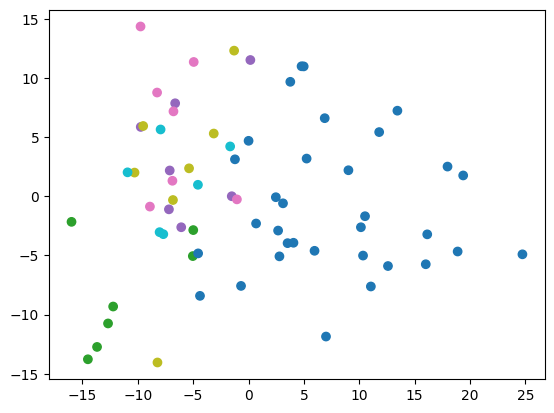

In [83]:
plt.scatter(flex_feats_te_pca[:, 0], flex_feats_te_pca[:, 2], c=flex_lbls_te, cmap='tab10')

In [93]:
print(pred_prob[:5])

[[0.99475729 0.93330157 0.84448242 0.96849746 0.98402792]
 [0.98498809 0.98779815 0.90229583 0.96094602 0.94390517]
 [0.99943072 0.99922752 0.99285215 0.99882525 0.99880505]
 [0.99992144 0.99653167 0.99973327 0.99360174 0.99968684]
 [0.99997699 0.99878615 0.99445033 0.99810034 0.99779522]]


In [95]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x, axis=1, keepdims=True)

print(softmax(pred_prob[:5]))

[[0.20989548 0.19738457 0.18060907 0.2044554  0.20765547]
 [0.20578492 0.206364   0.18945268 0.20089642 0.19750198]
 [0.20032015 0.20027945 0.19900665 0.2001989  0.20019485]
 [0.20040508 0.1997269  0.20036737 0.19914257 0.20035807]
 [0.20043116 0.20019262 0.1993265  0.20005537 0.19999434]]


In [ ]:
pred = self._logreg(torch.tensor(train_ds.ecog_feat.astype(np.float32)))
            pred = pred.squeeze().numpy()
            pred[pred>=0.5] = 1
            pred[pred<0.5] = 0
            score_train = balanced_accuracy_score(train_ds.ecog_lbl, pred)

(10.0, 100.0)

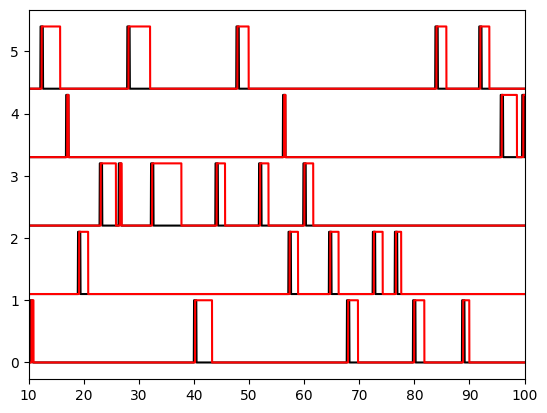

In [15]:
plt.plot(t,(flex_onwins>0)+np.arange(5)*1.1, 'k')
plt.plot(t_flex_events,flex_events+np.arange(5)*1.1, 'r')
plt.xlim(10, 100)

In [ ]:
# list mps devices
if torch.cuda.is_available(): # PC with GPU
    print('CUDA is available')
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # use neural engine on Mac
    print('MPS is available')
    device = torch.device('mps')
else:
    print('No GPU available, using CPU')
    device = torch.device('cpu')
    

When we did this last week, we were training the decoder to distinguish between the onset of a thumb movement and a period without thumb movements. But this is different from the problem we now face, which is to distinguish between Thumb vs. Index vs. Little finger movements. The optimal weights that separate thumb from not thumb movement are probably different from that separating Thumb from Index or Little finger. The randomly choosen no thumb movement periods we chose were likely to not have movement onset related activities present in them, and so the problem for that decoder was akin to our EEG decoder earlier in the course, which was detecting a pattern of activity rising above the background spontaneous activity in the brain. In contrast, comparing between different finger movements requires identifying activity patterns that distinguish between them. The challenge of this is immediately obvious when looking at similar activity patterns elicited with by different finger movements. A successful classifier will likely have to exploit those differences and minimize aspects that are similar.

Another, less obvious issue, is how the output of the decoder is configured. When training our 